In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
import random
import os
import sys
from collections import deque

In [2]:
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size,
                            kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        # x = tf.expand_dims(x, axis=0)
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q
    
    
    
        
        
        

In [4]:
class Agent():
    def __init__(self, state_size, action_size):
        self.render = False
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.memory = deque(maxlen=2000)
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.optimizer = Adam(learning_rate=self.learning_rate)
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(state)
            return np.argmax(q_value[0])
        
    def append_sample(self, state, action, reward, next_state, done):
        # print(state)
        self.memory.append((state, action, reward, next_state, done))
        
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        mini_batch = random.sample(self.memory, self.batch_size)
        # print(self.memory)
        # print(self.memory[0])
        
        # states = np.array([sample[0][0] if isinstance(sample[0][0], float) else sample[0][0][0] if isinstance(sample[0][0], np.ndarray) else sample[0] if isinstance(sample[0], float) else sample[0][0] for sample in mini_batch])

        states = np.array([sample[0][0] for sample in mini_batch])
        # print(states)
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])
        
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # states = tf.reshape(states, [-1, 1])
            # print(states)
            predicts = self.model(states)
            
            one_hot_action = tf.one_hot(actions, self.action_size)
            # print(one_hot_action)
            # # print(predicts)
            # predicts = np.squeeze(predicts, axis=0)
            # print(one_hot_action)
            # print("predicts",  predicts.shape)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)            
            
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)
            
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            # print("targets",  targets.shape)
            
            loss = tf.reduce_mean(tf.square(targets - predicts))
            # print("loss", loss)
            
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))
        
if __name__ == "__main__":
    env = gym.make('MountainCar-v0', render_mode='human')
    state_size = env.observation_space.shape[0]
    # print(env.observation_space)
    action_size = env.action_space.n
    
    agent = Agent(state_size, action_size)
    
    scores, episodes = [], []
    score_avg = 0
    
    num_episode = 1000
    for e in range(num_episode):
        done= False
        score = 0
        state = env.reset()[0]
        
        state = np.reshape(state, [1, state_size])
        
        
        
        while not done:
            if agent.render==True and e % 10 == 0:
                env.render()
                
            action = agent.get_action(state)
            next_state, reward, _, done, _ = env.step(action)
            
            next_state = np.reshape(next_state, [1, state_size])
            

            # 수정된 보상 계산

            if next_state[0, 0] >= 0.5:
                reward = 3  # 목표 지점에 도달한 경우
            else:
                if next_state[0, 0]<0:
                    reward = next_state[0, 0]*0.01
                else:
                    reward = next_state[0, 0]*0.1 # 실패한 경우
                
            score += reward
            
            agent.append_sample(state, action, reward, next_state, done)
            if len(agent.memory) >= agent.train_start:
                agent.train_model()
                
            state = next_state
            
            if done:
                agent.update_target_model()
                scores.append(score)
                episodes.append(e)
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {:3d} | score {:3.2f} | score avg {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                    e, score, score_avg, len(agent.memory), agent.epsilon))


                
                if score_avg > 90:
                    #save model
                    agent.model.save_weights("./save_model/model", save_format="tf")
                    sys.exit()
                    
            
       

episode:   0 | score -1.07 | score avg -1.07 | memory length:  200 | epsilon: 1.0000
episode:   1 | score -1.08 | score avg -1.07 | memory length:  400 | epsilon: 1.0000
episode:   2 | score -1.04 | score avg -1.07 | memory length:  600 | epsilon: 1.0000
episode:   3 | score -1.08 | score avg -1.07 | memory length:  800 | epsilon: 1.0000
episode:   4 | score -1.10 | score avg -1.07 | memory length: 1000 | epsilon: 0.9990
episode:   5 | score -1.05 | score avg -1.07 | memory length: 1200 | epsilon: 0.8178
episode:   6 | score -1.02 | score avg -1.07 | memory length: 1400 | epsilon: 0.6695
episode:   7 | score -1.02 | score avg -1.06 | memory length: 1600 | epsilon: 0.5481
episode:   8 | score -1.01 | score avg -1.06 | memory length: 1800 | epsilon: 0.4487
episode:   9 | score -1.03 | score avg -1.05 | memory length: 2000 | epsilon: 0.3673
episode:  10 | score -1.01 | score avg -1.05 | memory length: 2000 | epsilon: 0.3007
episode:  11 | score -0.92 | score avg -1.04 | memory length: 200

SystemExit: 

c:\Users\layen\anaconda3\envs\cuda\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


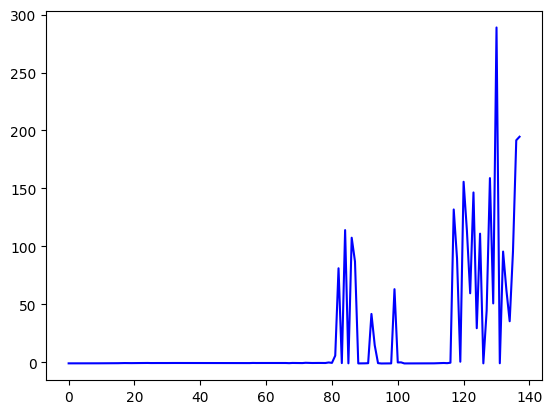

episode:   0 | score: 32.350310
episode:   1 | score: -1.045814
episode:   2 | score: -1.047127
episode:   3 | score: 31.388411
episode:   4 | score: 63.556754


In [5]:
# play saved model
agent.model.load_weights("./save_model/model")
agent.epsilon = 0.01

plt.plot(episodes, scores, 'b')
plt.show()

for e in range(5):
    
    done = False
    score = 0
    state = env.reset()[0]
    state = np.reshape(state, [1, state_size])
    
    while not done:
        env.render()
        action = agent.get_action(state)
        next_state, reward, _, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        if next_state[0, 0] >= 0.5:
                reward = 1  # 목표 지점에 도달한 경우
        else:
            if next_state[0, 0]<0:
                reward = next_state[0, 0]*0.01
            else:
                reward = next_state[0, 0]*0.1 # 실패한 경우
                
        score += reward
        state = next_state
        if done:
            print("episode: {:3d} | score: {:3f}".format(e, score))